# Learning optimal K for LDA

In this notebook, we learn an optimal topic representation from the unit descriptions for each recorded sale. Specifically, we use the following approach:
- We split the training data into a subtraining/validation set (80/20 split).
- We vectorize each document in the subtraining set using a simple count vectorizer
- For each candidate number of topics K, we:
    - Learn an LDA model on the subtraining counts
    - Featurize the subtraining and validation sets using this model (i.e the documents feature representation are its topic weights).
    - Use gradient boosting to learn a regression model to predict log(price)
    - Evaluate this model's performance using MSE on the validation set

In [2]:
import pandas as pd
import numpy as np

In [3]:
#Read in all data
df = pd.read_csv('./../scripts/sales_listings.1.csv.gz', header=0, usecols=['saleid', 'price','description'])
for i in range(2,5):
    df = df.append(pd.read_csv('./../processed_data/sales_listings.{}.csv'.format(i),
                               header=0, usecols=['saleid', 'price','description']), ignore_index=True)

In [4]:
df.head()

,saleid,price,description
0,building-1-5-avenue-new_york-18a,12230000,located in one of lower fifth avenues most pre...
1,building-1-dennett-place-brooklyn-house,1995000,in contract the best of the carroll gardens ...
2,building-1-east-66th-street-new_york-17ab,13900000,lovely traditional three bedroom home on hig...
3,building-1-east-end-avenue-new_york-12a,5495000,huge price reduction on this spectacular wate...
4,building-1-great-jones-alley-2a,4600000,residence 2aa collection of 16 artfully crafte...


In [5]:
print 'Shape with null descriptions', df.shape
df = df.dropna(axis=0, how='any')
print 'Shape without null vals', df.shape
df = df.loc[df['price'] > 1000, :]
print 'Shape without null vals or <1000 price', df.shape

Shape with null descriptions (377959, 3)
Shape without null vals (369266, 3)
Shape without null vals or <1000 price (369247, 3)


In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
Train_docs, Test_docs, Train_price, Test_price = train_test_split(train['description'], train['price'], test_size=0.2, random_state=42)

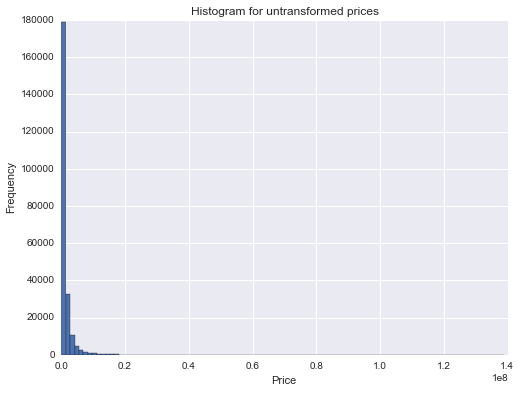

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(8,6))
plt.hist(Train_price.values, bins=100)
plt.title('Histogram for untransformed prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.savefig('figs/untransformed_prices.png')

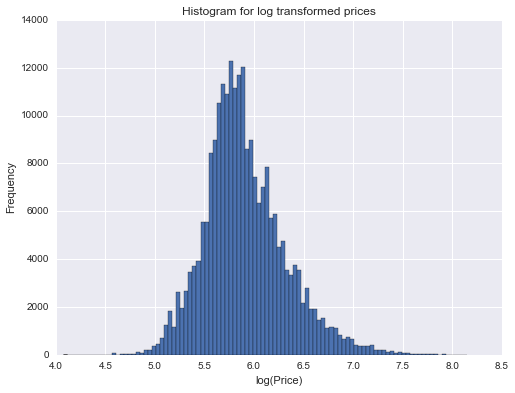

In [9]:
plt.figure(figsize=(8,6))
plt.hist(np.log10(Train_price.values), bins=100)
plt.title('Histogram for log transformed prices')
plt.xlabel('log(Price)')
plt.ylabel('Frequency')
plt.savefig('figs/log_transformed_prices.png')

In [10]:
#Use this log transform
Train_price = np.log10(Train_price.values)
Test_price = np.log10(Test_price.values)

In [11]:
#Baseline model: just predict the average log price
from sklearn.metrics import mean_squared_error

baseline_pred = np.ones_like(Test_price)*np.mean(Train_price)
baseline_mse = mean_squared_error(Test_price, baseline_pred)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#Use GradientBoostingRegressor to learn function from thetas to price
from sklearn.ensemble import GradientBoostingRegressor

#Note introduced hyperparameters: max_df, min_df
counter = CountVectorizer(stop_words='english', max_df = 0.9, min_df= 500)
train_counts = counter.fit_transform(Train_docs)

In [15]:
#Write vocab to file for use in R (slda)
with open('vocab.txt', 'w') as vocab:
    for word in counter.vocabulary_.keys():
          vocab.write("%s\n" % word)

In [16]:
#Write train/test docs and counts to files for R
Train_docs.to_csv('train_docs.csv')
Test_docs.to_csv('test_docs.csv')
with open('train_price.csv', 'w') as vocab:
    for price in Train_price:
          vocab.write("%s\n" % price)
with open('test_price.csv', 'w') as vocab:
    for price in Test_price:
          vocab.write("%s\n" % price)

In [108]:
models = {}
num_topics_to_test = [4,5] #Use to test code
#actual num_topics_to_test = sorted(range(5,35,5) + [4,6,7,8,9])
for n_topics in num_topics_to_test:
    print "Running K = {}\n".format(n_topics)
    print "\tLearning LDA model..."
    #Learn LDA model and get topic weights for training docs
    lda = LatentDirichletAllocation(n_topics=n_topics,
                                    max_iter=10,
                                    learning_method='online',
                                    n_jobs = -1, #Uses all cores,
                                    random_state=1234)
    topic_weights = lda.fit_transform(train_counts)
    
    #Learn GradientBoostedRegressor model of price ~ topic weights
    #Note this model was chosen since it is relatively immune to overfitting
    #and is non-linear (which is anticipated to improve performance)
    print "\tLearning GBR model..."
    gbr = GradientBoostingRegressor()
    gbr.fit(topic_weights, Train_price)
    
    print "\tGetting test-set GBR score..."
    #Transform test_docs to topic weight matrix
    test_topics = lda.transform(counter.transform(Test_docs))
    test_pred = gbr.predict(test_topics)
    mse = mean_squared_error(Test_price, test_pred)
    
    print "\tLearning linear model..."
    LS = LinearRegression(fit_intercept=False)
    LS.fit(topic_weights, Train_price)
    
    print '\Getting test-set linear predictions...'
    linear_test_pred = LS.predict(test_topics)
    mse_LS = mean_squared_error(Test_price, linear_test_pred)
    
    #Save model and score:
    print "\tSaving model...\n"
    models[n_topics] = {'lda': lda,
                        'gbr': gbr,
                        'ls': LS,
                        'mse_GBR': mse,
                        'mse_LS': mse_LS,
                        'test_pred_GBR': tst_pred,
                        'linear_test_pred': linear_test_pred}

Running K = 5

	Learning LDA model...
	Learning GBR model...
	Getting test-set score...
	Saving model...

Running K = 10

	Learning LDA model...
	Learning GBR model...
	Getting test-set score...
	Saving model...

Running K = 15

	Learning LDA model...
	Learning GBR model...
	Getting test-set score...
	Saving model...

Running K = 20

	Learning LDA model...
	Learning GBR model...
	Getting test-set score...
	Saving model...

Running K = 25

	Learning LDA model...
	Learning GBR model...
	Getting test-set score...
	Saving model...

Running K = 30

	Learning LDA model...
	Learning GBR model...
	Getting test-set score...
	Saving model...



ValueError: operands could not be broadcast together with shapes (59080,) (58253,) 

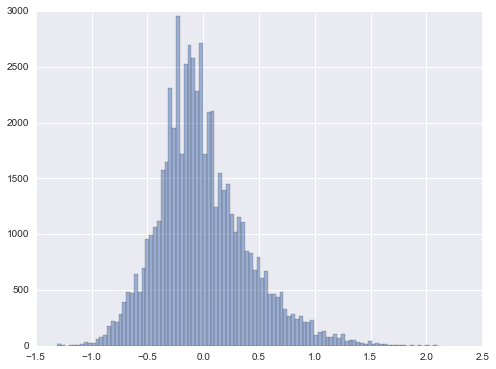

In [13]:
#Now make histogram of residuals for best python model

plt.figure(figsize=(8,6))
plt.hist(Test_price - baseline_pred, bins=100, label='Baseline: K = 0', alpha=0.5, label='Baseline (mean prediction)')
plt.hist(Test_price -  models[5]['test_pred_GBR'],
             bins=100, label='K = {}'.format(5), alpha=0.5, label='Using GradientBoostedRegression')
plt.legend()
plt.ylabel('Frequency')
plt.title('Comparing the distribution of residuals by K')
plt.xlabel('Residual (log(price) - predicted(log(price)))')
plt.legend(loc='best')
plt.savefig('figs/residuals.png')

In [ ]:
#Now run R code
import rpy2.robjects as robjects

robjects.r.source('sLDA.R')
#Note this saves MSEs for sLDA in file sLDA_MSEs.csv

sLDA_MSEs = pd.read_csv('sLDA_MSEs.csv', header=None)

In [ ]:
plt.plot([0] + models.keys(), [baseline_mse] + [models[K]['mse_GBR'] for K in models], label='Gradient Boosted model for LDA weights')
plt.plot([0] + models.keys(), [baseline_mse] + [models[K]['mse_LS'] for K in models], label='Linear model for LDA weights')
plt.plot([0] + list(sLDA_MSEs.loc[:,0]), [baseline_mse] + list(sLDA_MSEs.loc[:,1]), label='Lineader model for sLDA weights')
plt.xlabel('Number of topics K')
plt.ylabel('MSE for log(price) prediction')
plt.title('Learning curve: Optimizing K')
plt.legend(loc='best')
plt.savefig('figs/learning_curve.png')

In [115]:
#Use to visualize optimized model

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
vis15 = pyLDAvis.sklearn.prepare(models[5]['lda'], train_counts, counter)
pyLDAvis.save_html(vis5, 'LDAvis_5.html')

In [120]:
import pickle
pickle.dump(models, open( "LDA_models.p", "wb" ))

## Testing linear prediction
In this section, we test the performance of linear prediction for each value of K. This is being done to provide some comparable result to the sLDA model implemented in R.

In [12]:
import pickle
models = pickle.load(open('LDA_models.p','r'))

In [161]:
from sklearn.linear_model import LinearRegression

MSEs_linear = []

for num in models:
    print num
    lda = models[num]['lda']
    topic_weights = lda.transform(train_counts)
    
    print "learning linear model"
    LS = LinearRegression(fit_intercept=False)
    LS.fit(topic_weights, Train_price)
    
    print 'making predictions'
    test_topics = lda.transform(counter.transform(Test_docs))
    test_pred = LS.predict(test_topics)
    mse = mean_squared_error(Test_price, test_pred)
    
    MSEs_linear.append((num, mse))

4
learning linear model
making predictions


/Users/benjaminjakubowski/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


5
learning linear model
making predictions
6
learning linear model
making predictions
7
learning linear model
making predictions
8
learning linear model
making predictions
9
learning linear model
making predictions
10
learning linear model
making predictions
15
learning linear model
making predictions
20
learning linear model
making predictions
25
learning linear model
making predictions
30
learning linear model
making predictions


In [162]:
MSEs_linear = [(0, baseline_mse)] + MSEs_linear

[(4, 0.12911994761201154),
 (5, 0.096563016663734819),
 (6, 0.096178913763022289),
 (7, 0.097771404630269801),
 (8, 0.10062912323403821),
 (9, 0.088590009682886856),
 (10, 0.094434366749384199),
 (15, 0.085499675046259771),
 (20, 0.082613753569054565),
 (25, 0.085611145823950283),
 (30, 0.079621098487989858)]

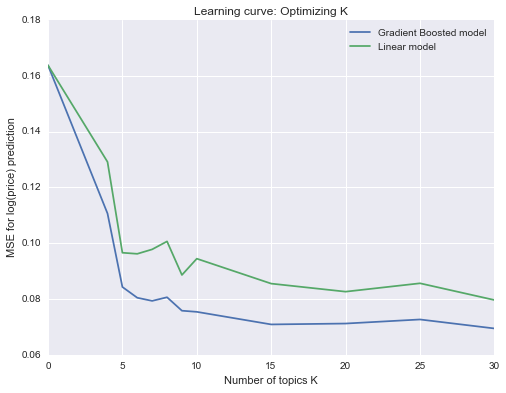

In [166]:
plt.figure(figsize=(8,6))
mses = [(0, baseline_mse)] + [(x, models[x]['mse']) for x in models]
plt.plot([x[0] for x in mses], [x[1] for x in mses], label='Gradient Boosted model')
plt.plot([x[0] for x in MSEs_linear], [x[1] for x in MSEs_linear], label='Linear model')
plt.xlabel('Number of topics K')
plt.ylabel('MSE for log(price) prediction')
plt.title('Learning curve: Optimizing K')
plt.legend()